In [69]:
import yasa
import numpy as np
import pandas as pd
import mne
import scipy.stats as sp_stats
import scipy.signal as sp_sig
import antropy as ant
from scipy.integrate import simps
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import robust_scale
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.options.display.precision = 10

In [2]:
def bandpower_from_psd_ndarray(psd, freqs, bands=[(0.5, 4, 'Delta'),
                               (4, 8, 'Theta'), (8, 12, 'Alpha'),
                               (12, 16, 'Sigma'), (16, 30, 'Beta'),
                               (30, 40, 'Gamma')], relative=True):
    # Type checks
    assert isinstance(bands, list), 'bands must be a list of tuple(s)'
    assert isinstance(relative, bool), 'relative must be a boolean'

    # Safety checks
    freqs = np.asarray(freqs)
    psd = np.asarray(psd)
    assert freqs.ndim == 1, 'freqs must be a 1-D array of shape (n_freqs,)'
    assert psd.shape[-1] == freqs.shape[-1], 'n_freqs must be last axis of psd'

    # Extract frequencies of interest
    all_freqs = np.hstack([[b[0], b[1]] for b in bands])
    fmin, fmax = min(all_freqs), max(all_freqs)
    idx_good_freq = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs = freqs[idx_good_freq]
    res = freqs[1] - freqs[0]

    # Trim PSD to frequencies of interest
    psd = psd[..., idx_good_freq]

    # Check if there are negative values in PSD
    if (psd < 0).any():
        msg = (
            "There are negative values in PSD. This will result in incorrect "
            "bandpower values. We highly recommend working with an "
            "all-positive PSD. For more details, please refer to: "
            "https://github.com/raphaelvallat/yasa/issues/29")
        logger.warning(msg)

    # Calculate total power
    total_power = simps(psd, dx=res, axis=-1)
    total_power = total_power[np.newaxis, ...]

    # Initialize empty array
    bp = np.zeros((len(bands), *psd.shape[:-1]), dtype=np.float)

    # Enumerate over the frequency bands
    labels = []
    for i, band in enumerate(bands):
        b0, b1, la = band
        labels.append(la)
        idx_band = np.logical_and(freqs >= b0, freqs <= b1)
        bp[i] = simps(psd[..., idx_band], dx=res, axis=-1)

    if relative:
        bp /= total_power
    return bp

def get_metrics(cm):
    if len(cm) == 0:
        cm = np.zeros((2,2), dtype=int)
    if np.squeeze(cm).ndim < 2:
        new_cm = np.zeros((2,2), dtype=int)
        new_cm[1, 1] = int(cm[0][0])
        cm = new_cm
    numerator = cm[0, 0] + cm[1, 1]
    denominator = cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0]
    accuracy = numerator / denominator
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    numerator = precision * recall
    denominator = (0.25 * precision) + recall
    f_score = 1.25 * numerator / denominator
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f_score': f_score}

In [116]:
raw = mne.io.read_raw_edf('C:\\Lilach\\406_for_tag_filtered.edf')
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
spikes_df = spikes_df[spikes_df['onset'] < end_onset]
spikes_df = spikes_df[spikes_df['description'].str.contains('Lt')]
# spikes_df.onset = spikes_df.onset.astype(int)
spikes_df = spikes_df.drop_duplicates(subset=['onset'])
sr = 1000
raw_data = raw.crop(tmax=end_onset).pick_channels(['LAH1']).resample(sr).get_data()[0]
len(spikes_df)

Extracting EDF parameters from C:\Lilach\406_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


24

In [117]:
epochs = []
window_size = int(sr / 4)
for i in range(0, len(raw_data), window_size):
    if i + window_size < len(raw_data):
        epochs.append(raw_data[i: i  + window_size])
epochs = np.array(epochs)

In [118]:
y_windows = np.zeros(len(epochs))
for onset in spikes_df['onset']:
    y_windows[int(onset * 1000 / window_size + 1)] = 1

In [119]:
spikes_df

,onset,duration,description,orig_time
1,2.5435,0.0,Lt spike,2008-03-03 22:40:00+00:00
3,5.4255,0.0,Lt spike,2008-03-03 22:40:00+00:00
5,5.8738,0.0,Lt spike,2008-03-03 22:40:00+00:00
6,13.2316,0.0,Lt spike,2008-03-03 22:40:00+00:00
8,19.0120,0.0,Lt spike,2008-03-03 22:40:00+00:00
10,21.8849,0.0,Lt spike,2008-03-03 22:40:00+00:00
12,39.7924,0.0,Lt spike,2008-03-03 22:40:00+00:00
20,72.4082,0.0,Lt spike,2008-03-03 22:40:00+00:00
24,77.2133,0.0,Lt spike,2008-03-03 22:40:00+00:00
27,88.4218,0.0,Lt spike,2008-03-03 22:40:00+00:00


In [120]:
#######################################################################
# MAIN PARAMETERS
#######################################################################

# Bandpass filter
freq_broad = (0.1, 500)
# FFT & bandpower parameters
win_sec = 5  # = 2 / freq_broad[0]
sf = sr
win = int(win_sec * sf)
kwargs_welch = dict(window='hamming', nperseg=win, average='median')
bands = [
    (0.1, 4, 'delta'), (4, 8, 'theta'),
    (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
    (30, 100, 'gamma'), (100, 500, 'fast')
]

In [121]:
#######################################################################
# CALCULATE FEATURES
#######################################################################

# times, epochs = sliding_window(raw.get_data(), sf=sf, window=1)
# epochs = np.squeeze(epochs)

# Calculate standard descriptive statistics
hmob, hcomp = ant.hjorth_params(epochs, axis=1)

feat = {
    'std': np.std(epochs, ddof=1, axis=1),
    'iqr': sp_stats.iqr(epochs, rng=(25, 75), axis=1),
    'skew': sp_stats.skew(epochs, axis=1),
    'kurt': sp_stats.kurtosis(epochs, axis=1),
    'nzc': ant.num_zerocross(epochs, axis=1),
    'hmob': hmob,
    'hcomp': hcomp
}

# Calculate spectral power features (for EEG + EOG)
freqs, psd = sp_sig.welch(epochs, sf, **kwargs_welch)
bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
for j, (_, _, b) in enumerate(bands):
    feat[b] = bp[j]

# Add power ratios for EEG
delta = feat['delta']
feat['dt'] = delta / feat['theta']
feat['ds'] = delta / feat['sigma']
feat['db'] = delta / feat['beta']
feat['dg'] = delta / feat['gamma']
feat['df'] = delta / feat['fast']
feat['at'] = feat['alpha'] / feat['theta']
feat['gt'] = feat['gamma'] / feat['theta']
feat['ft'] = feat['fast'] / feat['theta']
feat['ag'] = feat['gamma'] / feat['alpha']
feat['af'] = feat['fast'] / feat['alpha']

# Add total power
idx_broad = np.logical_and(
    freqs >= freq_broad[0], freqs <= freq_broad[1])
dx = freqs[1] - freqs[0]
feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)

# Calculate entropy and fractal dimension features
feat['perm'] = np.apply_along_axis(
    ant.perm_entropy, axis=1, arr=epochs, normalize=True)
feat['higuchi'] = np.apply_along_axis(
    ant.higuchi_fd, axis=1, arr=epochs)
feat['petrosian'] = ant.petrosian_fd(epochs, axis=1)

# Convert to dataframe
feat = pd.DataFrame(feat)
feat.index.name = 'epoch'

#######################################################################
# SMOOTHING & NORMALIZATION
#######################################################################

# Apply centered rolling average (15 epochs = 7 min 30)
# Triang: [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.,
#          0.875, 0.75, 0.625, 0.5, 0.375, 0.25, 0.125]
rollc = feat.rolling(
    window=2, center=True, min_periods=1, win_type='triang').mean()
rollc[rollc.columns] = robust_scale(rollc, quantile_range=(5, 95))
rollc = rollc.add_suffix('_cmin_norm')

# Now look at the past 2 minutes
rollp = feat.rolling(window=1, min_periods=1).mean()
rollp[rollp.columns] = robust_scale(rollp, quantile_range=(5, 95))
rollp = rollp.add_suffix('_pmin_norm')

# Add to current set of features
feat = feat.join(rollc).join(rollp)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 5000 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [122]:
epochs.shape

(783, 250)

In [123]:
feat

,std,iqr,skew,kurt,nzc,hmob,hcomp,delta,theta,alpha,...,df_pmin_norm,at_pmin_norm,gt_pmin_norm,ft_pmin_norm,ag_pmin_norm,af_pmin_norm,abspow_pmin_norm,perm_pmin_norm,higuchi_pmin_norm,petrosian_pmin_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,0.0000226028,0.0000343690,-0.1935738179,-0.9396785265,8,0.1142080099,8.2300442888,0.0,0.5356559587,0.2151612589,...,0.0,-0.0047633025,0.0207907188,-0.0086159053,0.0122375814,-0.0147231794,-0.0793596784,-0.6668613006,-0.1645363888,-0.6657977223
1,0.0000691971,0.0001188289,-0.1478740514,-1.0071696252,5,0.0770574297,9.5477541449,0.0,0.6746919045,0.2011610178,...,0.0,-0.0825458597,-0.0431192469,-0.0500034220,-0.0509353232,-0.0676051814,0.8481855132,-0.8668047515,-0.2787009781,-0.7823692160
2,0.0000635314,0.0000940847,0.8054965287,-0.5427548598,1,0.0475240979,19.0647853241,0.0,1.1712251512,0.0830862960,...,0.0,-0.2532589736,-0.0678734934,-0.0505377834,0.0169695779,-0.0090480845,0.1298813414,-0.5572649841,-0.2466571927,-0.5034926789
3,0.0000243747,0.0000249181,0.0088476335,0.4110223744,2,0.1192774051,7.5094157068,0.0,0.2547625010,0.3787405371,...,0.0,0.8104087800,0.2066638278,0.0753473247,-0.0254952531,-0.0358683064,-0.1326756971,-0.3856445912,-0.2105917237,-0.3881907789
4,0.0000312783,0.0000504259,-0.5884442708,-0.8833047506,2,0.0757101773,13.9508829703,0.0,0.8451734189,0.2110836195,...,0.0,-0.1189109446,-0.0457341976,-0.0344674216,-0.0412513748,-0.0288291506,-0.0631184251,-0.1804862064,-0.0305458004,-0.2276366801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.0000226561,0.0000421799,0.0121997048,-1.2767212195,0,0.1277192147,9.6231460437,0.0,0.2099886814,0.2496855658,...,0.0,0.5868122250,0.1252267943,0.1893622963,-0.0354151164,0.0308971159,-0.1082674833,0.1262879270,-0.0094326309,0.1356252358
779,0.0000364323,0.0000567301,0.3207321245,-1.0340125505,1,0.0819926489,14.6333278578,0.0,0.7093432404,0.2372357853,...,0.0,-0.0552784788,-0.0397317185,-0.0229821012,-0.0541230403,-0.0243037834,0.0340144269,0.2717898496,0.0504144169,0.2929643978
780,0.0000294421,0.0000347861,1.0203008926,0.1788386217,15,0.0997640192,11.8008324767,0.0,0.5100955721,0.3491027311,...,0.0,0.2076459935,-0.0515426634,-0.0253949631,-0.1015553025,-0.0584515394,0.0855536341,0.1497608106,-0.0787906779,0.1130702602


In [124]:
feat = feat.loc[:, (feat != 0).any(axis=0)]
feat.shape

(783, 66)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(feat, y_windows, stratify=y_windows)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

(587, 66) (587,) (196, 66) (196,)
[0. 1.] [569  18]


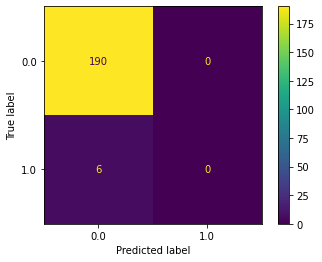

In [126]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
plot_confusion_matrix(classifier, X_test, y_test)  

In [127]:
cm = confusion_matrix(y_test, y_pred)
get_metrics(cm)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in longlong_scalars


{'accuracy': 0.9693877551020408,
 'precision': nan,
 'recall': 0.0,
 'f_score': nan}

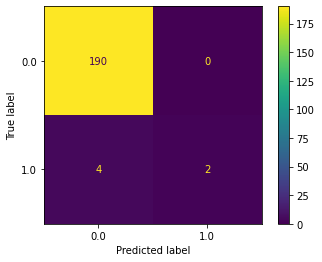

In [128]:
# Define hyper-parameters
params = dict(
    boosting_type='gbdt',
    n_estimators=400,
    max_depth=5,
    num_leaves=90,
    colsample_bytree=0.5,
    importance_type='gain',
)
clf = LGBMClassifier(**params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)  

[17:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


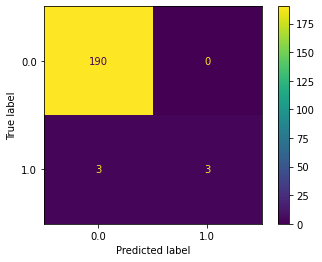

In [129]:
clf = xgb.XGBClassifier(objective="multi:softmax", num_class=3, use_label_encoder=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)  